In [1]:
%run 00_Dataset.ipynb

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
if dataset == 'Pantheon':
    skip_header = 6
else :
    skip_header = 0
    
df_SNe = pd.read_excel('../data/quasar/QuasarDataset.xlsx')

df_SNe = pd.DataFrame(df_SNe)

In [4]:
GRB = pd.read_csv(os.path.join(out_dir,'GRB_'+dataset+'.csv'))

In [5]:
with open(os.path.join(out_dir, 'BestFitParameters.pickle'), 'rb') as handle:
    BestFitParameters = pickle.load(handle)

In [6]:
def calculate_E_gamma_from_correlation(log_E_peak_i, log_E_peak_i_err): 
 
    # get best fit parameters for correlation 
    a = BestFitParameters['E_peak-E_gamma']['All-z']['a'] 
    a_err = BestFitParameters['E_peak-E_gamma']['All-z']['a_err'] 
    b = BestFitParameters['E_peak-E_gamma']['All-z']['b']
    b_err = BestFitParameters['E_peak-E_gamma']['All-z']['b_err']

    # log transformed, normalized E_peak
    log_E_gamma = a + b * log_E_peak_i
    log_E_gamma_err = np.sqrt(a_err**2 + (abs(b * log_E_peak_i) * np.sqrt((b_err/b)**2 + (log_E_peak_i_err/log_E_peak_i)**2))**2)

    E_gamma = 10 ** log_E_gamma

    E_gamma_err = abs(E_gamma) * abs(np.log(10) * log_E_gamma_err)

    return E_gamma, E_gamma_err

def calculate_E_iso(E_gamma, E_gamma_err, F_beam, F_beam_err):

    E_iso = E_gamma / F_beam
    E_iso_err = abs(E_iso) * np.sqrt( (E_gamma_err/E_gamma)**2 + (F_beam_err/F_beam)**2 )

    return E_iso, E_iso_err


def calculate_d_L(E_iso, E_iso_err, S_bolo, S_bolo_err, z):

    # calculate d_L
    a = E_iso * (1. + z)
    a_err = (1.+z) * E_iso_err

    b = 4. * np.pi * S_bolo
    b_err = 4. * np.pi * S_bolo_err

    c = a/b
    c_err = abs(c) * np.sqrt((a_err/a)**2 + (b_err/b)**2)

    d_L = np.sqrt(c) 
    d_L_err = c_err / (2*np.sqrt(c))

    return d_L, d_L_err

    
def caliberate_d_L(log_E_peak_i, log_E_peak_i_err, F_beam, F_beam_err, S_bolo, S_bolo_err, z):
    
    # calculate E_gamma from E_gamma-E_peak correlation
    E_gamma, E_gamma_err = calculate_E_gamma_from_correlation(log_E_peak_i, log_E_peak_i_err)

    # calculate E_iso
    E_iso, E_iso_err = calculate_E_iso(E_gamma, E_gamma_err, F_beam, F_beam_err)

    # calculate d_L
    d_L, d_L_err = calculate_d_L(E_iso, E_iso_err, S_bolo, S_bolo_err, z)

    return d_L, d_L_err

def caliberate_mu(d_L, d_L_err):

    # calculate mu
    mu = 5. * np.log10(d_L / (10**6 * 2.998e+18)) + 25.
    mu_err = abs(5. * d_L_err / (d_L * np.log(10))) 

    return mu, mu_err

In [7]:
def test_calculate_E_gamma_from_correlation(GRB) :
    test = GRB.dropna(subset=['E_gamma'])
    E_gamma = test['E_gamma'].iloc(0)[0]
    log_E_peak_i = test['log_E_peak_i'].iloc(0)[0]
    log_E_peak_i_err = test['log_E_peak_i_err'].iloc(0)[0]
    
    print(f'Expected : {E_gamma}')
    print(f'Outcome : {calculate_E_gamma_from_correlation(log_E_peak_i, log_E_peak_i_err)}')

test_calculate_E_gamma_from_correlation(GRB)

Expected : 3.400832097425808e+49
Outcome : (6.668213969040001e+50, 5.506814752582046e+50)


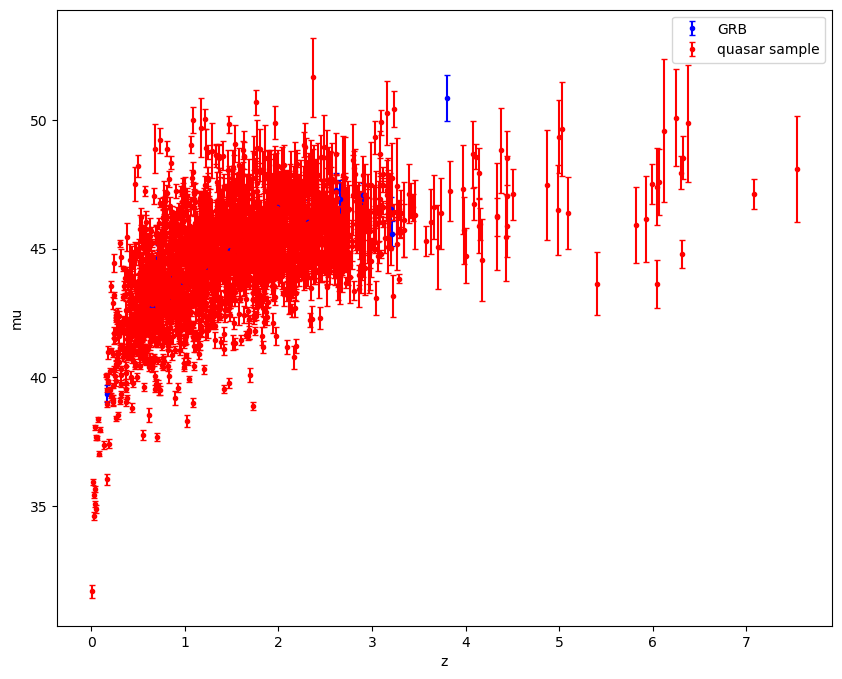

In [8]:
# caliberate d_L from E_peak - E_gamma relation, hence only those GRBs with 
# sufficient data(E_peak, F_beam, S_bolo) can be caliberated using from this 
filtered_GRB = GRB[['E_gamma', 'E_gamma_err','log_E_peak_i', 'log_E_peak_i_err', 'F_beam', 'F_beam_err', 'S_bolo', 'S_bolo_err', 'z']].dropna()

d_L, d_L_err = caliberate_d_L(
    filtered_GRB['log_E_peak_i'].to_numpy(), 
    filtered_GRB['log_E_peak_i_err'].to_numpy(),
    filtered_GRB['F_beam'].to_numpy(),
    filtered_GRB['F_beam_err'].to_numpy(),
    filtered_GRB['S_bolo'].to_numpy(),
    filtered_GRB['S_bolo_err'].to_numpy(),
    filtered_GRB['z'].to_numpy())

mu_GRB, mu_err_GRB = caliberate_mu(d_L, d_L_err)

fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('white')

ax.errorbar(filtered_GRB['z'].to_numpy(), mu_GRB, yerr=mu_err_GRB, fmt='.', color='b', capsize=2, label='GRB')
ax.errorbar(df_SNe['z'], df_SNe['DM'], yerr=df_SNe['e_DM'], fmt='.r', capsize=2, label=dataset+' sample')
ax.legend()
ax.set_xlabel('z')
ax.set_ylabel('mu')
plt.savefig(os.path.join(out_dir,'16_GRB_reconstruction.pdf'))
plt.show()